# Test $\mu^*$ calibration
Since I'm obviously to stupid to come up with some structured testing regime, I'll just start here and see where I get.

In [1]:
# IMPORT ALL THE STUFF
# I'm probably needing not even the half of it, but hey...

# External libs
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
import os
import shutil
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

# import unittest
import unittest
import pytest

# import gis libs
import salem
import rasterio
import geopandas as gpd
import shapely.geometry as shpg


# import OGGM modules
import oggm
import oggm.cfg as cfg
from oggm.cfg import SEC_IN_YEAR, SEC_IN_MONTH, BASENAMES

from oggm import utils
from oggm.utils import get_demo_file, tuple2int
from oggm.utils import (SuperclassMeta, lazy_property, floatyear_to_date,
                        date_to_floatyear, monthly_timeseries, ncDataset,
                        tolist)

from oggm import workflow

from oggm.core import (gis, inversion, climate, centerlines, flowline,
                       massbalance)

from oggm.core.massbalance import MassBalanceModel

from oggm.tests.funcs import get_test_dir, patch_url_retrieve_github

In [8]:
# load the new module
import importlib
from oggm.core import vascaling
from oggm.tests import test_vascaling

## Test the internal functions computing terminus temperature and solid precipitation

In [9]:
test = test_vascaling.TestVAScalingModel()
test.setUp()

2019-05-09 13:30:48: oggm.cfg: Using configuration file: /Users/oberrauch/oggm-fork/oggm/params.cfg
2019-05-09 13:30:48: oggm.utils: Downloading https://github.com/OGGM/oggm-sample-data/archive/1e67ee089d58a8171342b948a68b4cf09a8d948c.zip to /Users/oberrauch/OGGM/download_cache/github.com/OGGM/oggm-sample-data/archive/1e67ee089d58a8171342b948a68b4cf09a8d948c.zip...
-  -1.0 B Elapsed Time: 0:03:57                                                2019-05-09 13:34:51: oggm.utils: Successfully loaded verification data.
2019-05-09 13:34:51: oggm.utils: No known hash for /Users/oberrauch/OGGM/download_cache/github.com/OGGM/oggm-sample-data/archive/1e67ee089d58a8171342b948a68b4cf09a8d948c.zip: 37818243 284530f8c3c767e26deedd2db6233d64cef3c7ab1113bc2d404eaf38528e1055
|  -1.0 B Elapsed Time: 0:04:01                                                


### Test solid precipitation

In [11]:
self = test

In [12]:
""" Tests the subroutine which computes solid precipitation amount from
given total precipitation and temperature. """

# read the Hintereisferner DEM
hef_file = get_demo_file('Hintereisferner_RGI5.shp')
entity = gpd.read_file(hef_file).iloc[0]

# initialize the GlacierDirectory
gdir = oggm.GlacierDirectory(entity, base_dir=self.testdir)
# define the local grid
gis.define_glacier_region(gdir, entity=entity)
# process the given climate file
climate.process_custom_climate_data(gdir)

# read the following variable from the center pixel (46.83N 10.75E)
# of the Hintereisferner HistAlp climate file for the
# entire time period from October 1801 until September 2003
# - surface height in m asl.
# - total precipitation amount in kg/m2
# - 2m air temperature in °C
with utils.ncDataset(get_demo_file('histalp_merged_hef.nc')) as nc_r:
    ref_h = nc_r.variables['hgt'][1, 1]
    ref_p = nc_r.variables['prcp'][:, 1, 1]
    ref_t = nc_r.variables['temp'][:, 1, 1]

# define needed parameters
prcp_factor = 1
temp_all_solid = 0
temp_grad = -0.0065

# define elevation levels
ref_hgt = ref_h
min_hgt = ref_h - 100
max_hgt = ref_h + 100

# if the terminus temperature is below the threshold for
# solid precipitation all fallen precipitation must be solid
temp_terminus = ref_t * 0 + temp_all_solid
solid_prcp = vascaling._compute_solid_prcp(ref_p, prcp_factor, ref_hgt,
                                           min_hgt, max_hgt,
                                           temp_terminus,
                                           temp_all_solid, temp_grad,
                                           prcp_grad=0, prcp_anomaly=0)
np.testing.assert_allclose(solid_prcp, ref_p)

# if the temperature at the maximal elevation is above the threshold
# for solid precipitation all fallen precipitation must be liquid
temp_terminus = ref_t + 100
solid_prcp = vascaling._compute_solid_prcp(ref_p, prcp_factor, ref_hgt,
                                           min_hgt, max_hgt,
                                           temp_terminus,
                                           temp_all_solid, temp_grad,
                                           prcp_grad=0, prcp_anomaly=0)
np.testing.assert_allclose(solid_prcp, 0)

2019-05-09 13:35:41: oggm.core.gis: (RGI50-11.00897) define_glacier_region
2019-05-09 13:35:41: oggm.core.climate: (RGI50-11.00897) process_custom_climate_data


In [21]:
# test extreme case if max_hgt equals min_hgt
solid_prcp = vascaling._compute_solid_prcp(ref_p, prcp_factor, ref_hgt,
                                           ref_h, ref_h,
                                           ref_t,
                                           temp_all_solid, temp_grad,
                                           prcp_grad=0, prcp_anomaly=0)

In [28]:
test_p = ref_p * (ref_t <= temp_all_solid).astype(int)

array([0., 0., 0., ..., 0., 0., 0.])

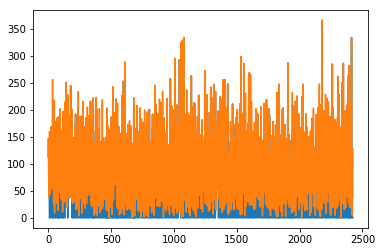

In [24]:
plt.plot(solid_prcp)
plt.plot()

In [18]:
test.test_terminus_temp()
test.test_solid_prcp()

2019-01-09 14:05:38: oggm.core.gis: (RGI50-11.00897) define_glacier_region
2019-01-09 14:05:38: oggm.core.climate: (RGI50-11.00897) process_custom_climate_data
2019-01-09 14:05:38: oggm.core.gis: (RGI50-11.00897) define_glacier_region
2019-01-09 14:05:38: oggm.core.climate: (RGI50-11.00897) process_custom_climate_data


In [19]:
test.test_min_max_elevation()

2019-01-09 14:05:38: oggm.core.gis: (RGI50-11.00897) define_glacier_region
2019-01-09 14:05:39: oggm.core.gis: (RGI50-11.00897) glacier_masks


In [189]:
test.test_yearly_mb_temp_prcp()

2019-01-06 16:41:55: oggm.core.gis: (RGI50-11.00897) define_glacier_region
2019-01-06 16:41:55: oggm.core.gis: (RGI50-11.00897) glacier_masks
2019-01-06 16:41:56: oggm.core.gis: (RGI50-11.00897) glacier_masks
2019-01-06 16:41:56: oggm.core.centerlines: (RGI50-11.00897) compute_centerlines
2019-01-06 16:41:57: oggm.core.centerlines: (RGI50-11.00897) initialize_flowlines
2019-01-06 16:41:57: oggm.core.centerlines: (RGI50-11.00897) catchment_area
2019-01-06 16:42:00: oggm.core.centerlines: (RGI50-11.00897) catchment_intersections
2019-01-06 16:42:00: oggm.core.centerlines: (RGI50-11.00897) catchment_width_geom
2019-01-06 16:42:02: oggm.core.centerlines: (RGI50-11.00897) catchment_width_correction
2019-01-06 16:42:02: oggm.core.climate: (RGI50-11.00897) process_custom_climate_data


In [205]:
test.test_local_t_star()

2019-01-06 16:46:17: oggm.core.gis: (RGI50-11.00897) define_glacier_region
2019-01-06 16:46:17: oggm.core.gis: (RGI50-11.00897) glacier_masks
2019-01-06 16:46:17: oggm.core.centerlines: (RGI50-11.00897) compute_centerlines
2019-01-06 16:46:17: oggm.core.centerlines: (RGI50-11.00897) initialize_flowlines
2019-01-06 16:46:18: oggm.core.centerlines: (RGI50-11.00897) catchment_area
2019-01-06 16:46:20: oggm.core.centerlines: (RGI50-11.00897) catchment_intersections
2019-01-06 16:46:20: oggm.core.centerlines: (RGI50-11.00897) catchment_width_geom
2019-01-06 16:46:21: oggm.core.centerlines: (RGI50-11.00897) catchment_width_correction
2019-01-06 16:46:21: oggm.core.climate: (RGI50-11.00897) process_custom_climate_data
2019-01-06 16:46:22: oggm.core.climate: (RGI50-11.00897) t_star_from_refmb


In [180]:
test.test_monthly_climate()

2019-01-13 19:02:26: oggm.core.gis: (RGI50-11.00897) define_glacier_region
2019-01-13 19:02:26: oggm.core.gis: (RGI50-11.00897) glacier_masks
2019-01-13 19:02:27: oggm.core.climate: (RGI50-11.00897) process_custom_climate_data
2019-01-13 19:02:27: oggm.core.centerlines: (RGI50-11.00897) compute_centerlines
2019-01-13 19:02:27: oggm.core.centerlines: (RGI50-11.00897) initialize_flowlines
2019-01-13 19:02:27: oggm.core.centerlines: (RGI50-11.00897) catchment_area
2019-01-13 19:02:29: oggm.core.centerlines: (RGI50-11.00897) catchment_intersections
2019-01-13 19:02:29: oggm.core.centerlines: (RGI50-11.00897) catchment_width_geom
2019-01-13 19:02:30: oggm.core.centerlines: (RGI50-11.00897) catchment_width_correction
2019-01-13 19:02:30: oggm.core.climate: (RGI50-11.00897) t_star_from_refmb
2019-01-13 19:02:31: oggm.core.climate: (RGI50-11.00897) local_t_star
2019-01-13 19:02:31: oggm.core.climate: (RGI50-11.00897) local mu* for t*=1879
2019-01-13 19:02:31: oggm.core.climate: (RGI50-11.00897

In [177]:
test.test_annual_climate()

2019-01-13 18:58:57: oggm.core.gis: (RGI50-11.00897) define_glacier_region
2019-01-13 18:58:57: oggm.core.gis: (RGI50-11.00897) glacier_masks
2019-01-13 18:58:57: oggm.core.climate: (RGI50-11.00897) process_custom_climate_data
2019-01-13 18:58:57: oggm.core.centerlines: (RGI50-11.00897) compute_centerlines
2019-01-13 18:58:57: oggm.core.centerlines: (RGI50-11.00897) initialize_flowlines
2019-01-13 18:58:58: oggm.core.centerlines: (RGI50-11.00897) catchment_area
2019-01-13 18:59:00: oggm.core.centerlines: (RGI50-11.00897) catchment_intersections
2019-01-13 18:59:00: oggm.core.centerlines: (RGI50-11.00897) catchment_width_geom
2019-01-13 18:59:01: oggm.core.centerlines: (RGI50-11.00897) catchment_width_correction
2019-01-13 18:59:01: oggm.core.climate: (RGI50-11.00897) t_star_from_refmb
2019-01-13 18:59:01: oggm.core.climate: (RGI50-11.00897) local_t_star
2019-01-13 18:59:01: oggm.core.climate: (RGI50-11.00897) local mu* for t*=1879
2019-01-13 18:59:01: oggm.core.climate: (RGI50-11.00897

In [424]:
test.test_specific_mb()
test.test_monthly_specific_mb()

2019-01-14 18:29:11: oggm.core.gis: (RGI50-11.00897) define_glacier_region
2019-01-14 18:29:11: oggm.core.gis: (RGI50-11.00897) glacier_masks
2019-01-14 18:29:12: oggm.core.climate: (RGI50-11.00897) process_custom_climate_data
2019-01-14 18:29:12: oggm.core.centerlines: (RGI50-11.00897) compute_centerlines
2019-01-14 18:29:12: oggm.core.centerlines: (RGI50-11.00897) initialize_flowlines
2019-01-14 18:29:13: oggm.core.centerlines: (RGI50-11.00897) catchment_area
2019-01-14 18:29:15: oggm.core.centerlines: (RGI50-11.00897) catchment_intersections
2019-01-14 18:29:15: oggm.core.centerlines: (RGI50-11.00897) catchment_width_geom
2019-01-14 18:29:16: oggm.core.centerlines: (RGI50-11.00897) catchment_width_correction
2019-01-14 18:29:16: oggm.core.climate: (RGI50-11.00897) t_star_from_refmb
2019-01-14 18:29:16: oggm.core.climate: (RGI50-11.00897) local_t_star
2019-01-14 18:29:16: oggm.core.climate: (RGI50-11.00897) local mu* for t*=1879
2019-01-14 18:29:17: oggm.core.climate: (RGI50-11.00897

In [425]:
gdir.rgi_area_km2

8.036

### Test $\mu^*$ calibration
Run the local t$^*$ test, simulating an "in-class" environment.

In [156]:
# quick and dirty
self = test

# read the Hintereisferner DEM
hef_file = get_demo_file('Hintereisferner_RGI5.shp')
entity = gpd.read_file(hef_file).iloc[0]

In [157]:
# initialize the GlacierDirectory
gdir = oggm.GlacierDirectory(entity, base_dir=self.testdir)
# define the local grid and the glacier mask
gis.define_glacier_region(gdir, entity=entity)
gis.glacier_masks(gdir)
# run centerline prepro tasks
centerlines.compute_centerlines(gdir)
centerlines.initialize_flowlines(gdir)
centerlines.catchment_area(gdir)
centerlines.catchment_width_geom(gdir)
centerlines.catchment_width_correction(gdir)

2019-01-06 15:02:24: oggm.core.gis: (RGI50-11.00897) define_glacier_region
2019-01-06 15:02:24: oggm.core.gis: (RGI50-11.00897) glacier_masks
2019-01-06 15:02:24: oggm.core.centerlines: (RGI50-11.00897) compute_centerlines
2019-01-06 15:02:25: oggm.core.centerlines: (RGI50-11.00897) initialize_flowlines
2019-01-06 15:02:25: oggm.core.centerlines: (RGI50-11.00897) catchment_area
2019-01-06 15:02:27: oggm.core.centerlines: (RGI50-11.00897) catchment_width_geom
2019-01-06 15:02:28: oggm.core.centerlines: (RGI50-11.00897) catchment_width_correction


In [158]:
# process the given climate file
climate.process_custom_climate_data(gdir)
# compute mu candidates for every 31 year period
climate.glacier_mu_candidates(gdir)
# read reference glacier mass balance data
mbdf = gdir.get_ref_mb_data()
# compute the reference t* for the glacier
# given the reference of mass balance measurements
res = climate.t_star_from_refmb(gdir, mbdf=mbdf['ANNUAL_BALANCE'])
t_star, bias = res['t_star'], res['bias']

2019-01-06 15:02:28: oggm.core.climate: (RGI50-11.00897) process_custom_climate_data
2019-01-06 15:02:28: oggm.core.climate: (RGI50-11.00897) glacier_mu_candidates
2019-01-06 15:02:28: oggm.core.climate: (RGI50-11.00897) t_star_from_refmb


In [159]:
# compute local t* and the corresponding mu*
climate.local_t_star(gdir, tstar=t_star, bias=bias)
# compute the mu* for each flow line
climate.mu_star_calibration(gdir)
# use the mu candidate at t* as glacier wide reference value
ci = gdir.read_pickle('climate_info')
mu_ref = ci['mu_candidates_glacierwide'].loc[t_star]

2019-01-06 15:02:28: oggm.core.climate: (RGI50-11.00897) local_t_star
2019-01-06 15:02:28: oggm.core.climate: (RGI50-11.00897) local mu* for t*=1879
2019-01-06 15:02:28: oggm.core.climate: (RGI50-11.00897) mu_star_calibration


Hereafter I compute t* and mu* using my function.

In [160]:
# compute local t* and the corresponding mu*
ben.local_t_star(gdir, tstar=t_star, bias=bias)
ben_params = gdir.read_json('ben_params')
ben_params

{'rgi_id': 'RGI50-11.00897',
 't_star': 1879,
 'bias': -12.407469330645313,
 'mu_star': 70.48519842109663}

This can obviousoly not be applied in the same way...!

In [161]:
# use the mu candidate at t* as glacier wide reference value
ci = gdir.read_pickle('climate_info')
mu_ref = ci['mu_candidates_glacierwide'].loc[t_star]
mu_ref

199.26910886614405

In [162]:
import importlib
importlib.reload(ben)

<module 'oggm.core.ben' from '/Users/oberrauch/oggm/oggm/core/ben.py'>

In [176]:
# get min and max glacier elevation
min_hgt, max_hgt = ben.get_min_max_elevation(gdir)

# Check for apparent mb to be zeros
# ---------------------------------
ben_mb = ben.BenMassBalance(gdir, mu_star=ben_params['mu_star'], bias=bias)
# define 31-year climate period around t*
mu_hp = int(cfg.PARAMS['mu_star_halfperiod'])
years = np.arange(t_star-mu_hp, t_star+mu_hp+1)
# iterate over all years in climate period
# and sum specific mass balance
mbs = np.empty(years.size)
for i, year in enumerate(years):
    mbs[i] = ben_mb.get_specific_mb(min_hgt, max_hgt, year)
    
print('Sum over climate period: {:.0f} mm w.e. year'.format(mbs.sum()))

Sum over climate period: 385 mm w.e. year


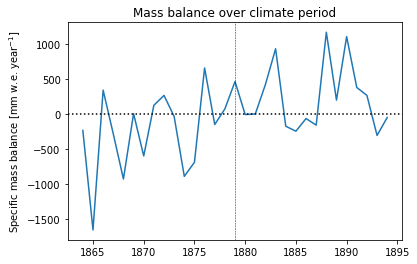

In [164]:
# visualize mass balance
plt.plot(years, mbs)
plt.ylabel('Specific mass balance [mm w.e. year$^{-1}$]')
plt.title('Mass balance over climate period')
# aux line
plt.axhline(0, c='k', ls=':')
plt.axvline(t_star, c='b', ls='--', lw=0.5)

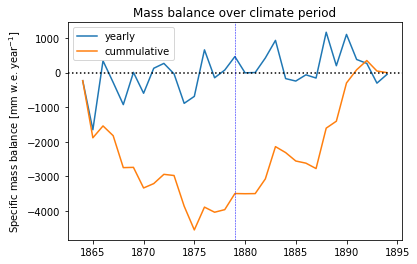

In [165]:
plt.plot(years, mbs, label='yearly')
plt.plot(years, mbs.cumsum(), label='cummulative')
plt.ylabel('Specific mass balance [mm w.e. year$^{-1}$]')
plt.title('Mass balance over climate period')
# aux line
plt.axhline(0, c='k', ls=':')
plt.axvline(t_star, c='b', ls='--', lw=0.5)
plt.legend()

In [166]:
# check with calibration
years, temp, prcp = ben.get_yearly_mb_temp_prcp(gdir, year_range=[min(years), max(years)])
# compute mu*
mu_star = np.mean(prcp)/np.mean(temp)
# check if same mu*
assert(mu_star == ben_params['mu_star'])

# iterate over all years in climate period
# and sum specific mass balance
mbs_by_hand = np.empty(years.size)
for i, year in enumerate(years):
    mbs_by_hand[i] = (prcp[i] - mu_star * temp[i])
    
print('Sum over climate period: {:.0f} mm w.e. year'.format(mbs_by_hand.sum()))

Sum over climate period: 0 mm w.e. year


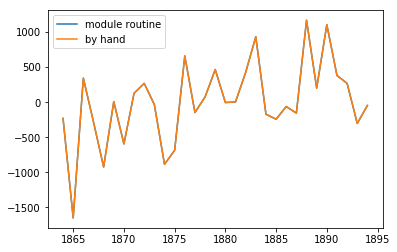

In [167]:
plt.plot(years, mbs, label='module routine')
plt.plot(years, mbs_by_hand, label='by hand')
plt.legend()

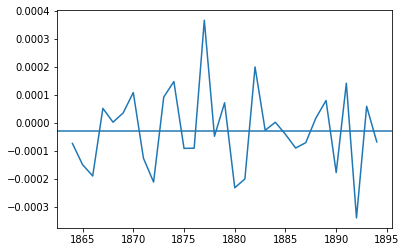

In [168]:
plt.plot(years, mbs - mbs_by_hand)
plt.axhline(np.mean(mbs - mbs_by_hand))

The difference lies in the method used to gather climate information, which is `get_annual_climate` for the mass balance routine and `get_yearly_mb_temp_prcp` during the calibration.

In [169]:
climate =  np.array([ben_mb.get_annual_climate(min_hgt, max_hgt, year) for year in years])
temp_mb = climate[:, 0].sum(axis=1)
prcp_mb = climate[:, 1].sum(axis=1)

In [170]:
years, temp_calib, prcp_calib = ben.get_yearly_mb_temp_prcp(gdir, year_range=[min(years), max(years)])

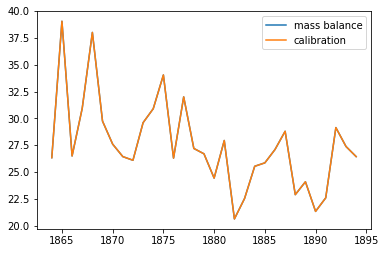

In [171]:
plt.plot(years, temp_mb, label='mass balance')
plt.plot(years, temp_calib, label='calibration')
plt.legend()

In [172]:
# check if temperature is equal
np.testing.assert_array_equal(temp_mb, temp_calib)

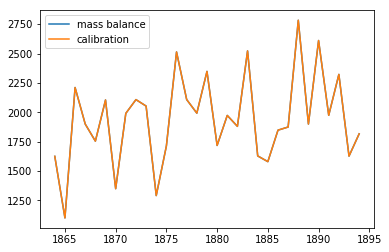

In [173]:
plt.plot(years, prcp_mb, label='mass balance')
plt.plot(years, prcp_calib, label='calibration')
plt.legend()

In [174]:
# check if temperature is equal
np.testing.assert_array_equal(prcp_mb, prcp_calib)

In [175]:
prcp_mb/prcp_calib

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

## Test prepro climate task

In [37]:
# read the Hintereisferner DEM
hef_file = get_demo_file('Hintereisferner_RGI5.shp')
entity = gpd.read_file(hef_file).iloc[0]

# initialize the GlacierDirectory
gdir = oggm.GlacierDirectory(entity, base_dir=self.testdir)
# define the local grid and glacier mask
gis.define_glacier_region(gdir, entity=entity)
gis.glacier_masks(gdir)
# run centerline prepro tasks
centerlines.compute_centerlines(gdir)
centerlines.initialize_flowlines(gdir)
centerlines.catchment_area(gdir)
centerlines.catchment_intersections(gdir)
centerlines.catchment_width_geom(gdir)
centerlines.catchment_width_correction(gdir)
# process the given climate file
climate.process_custom_climate_data(gdir)

# get yearly sums of terminus temperature and solid precipitation
years, temp, prcp = vascaling.get_yearly_mb_temp_prcp(gdir)

# use the OGGM methode to get the mass balance
# relevant climate parameters
years_oggm, temp_oggm, prcp_oggm = \
    climate.mb_yearly_climate_on_glacier(gdir)

2019-01-30 14:39:21: oggm.core.gis: (RGI50-11.00897) define_glacier_region
2019-01-30 14:39:21: oggm.core.gis: (RGI50-11.00897) glacier_masks
2019-01-30 14:39:22: oggm.core.centerlines: (RGI50-11.00897) compute_centerlines
2019-01-30 14:39:22: oggm.core.centerlines: (RGI50-11.00897) initialize_flowlines
2019-01-30 14:39:22: oggm.core.centerlines: (RGI50-11.00897) catchment_area
2019-01-30 14:39:24: oggm.core.centerlines: (RGI50-11.00897) catchment_intersections
2019-01-30 14:39:24: oggm.core.centerlines: (RGI50-11.00897) catchment_width_geom
2019-01-30 14:39:26: oggm.core.centerlines: (RGI50-11.00897) catchment_width_correction
2019-01-30 14:39:26: oggm.core.climate: (RGI50-11.00897) process_custom_climate_data


In [42]:
from oggm.utils import md

mean deviation [°C]: 17.74336609112132


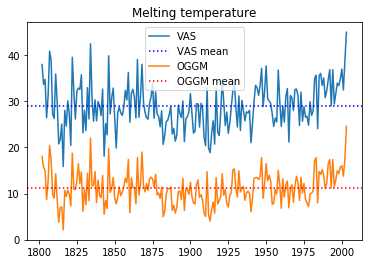

In [61]:
plt.plot(years, temp, label='VAS')
plt.axhline(temp.mean(), c='b', ls=':', label='VAS mean')
plt.plot(years_oggm, temp_oggm, label='OGGM')
plt.axhline(temp_oggm.mean(), c='r', ls=':', label='OGGM mean')
plt.legend()
plt.title('Melting temperature')
print('mean deviation [°C]:',md(temp_oggm, temp))

mean deviation [mm w.e. yr-1]: -150.67980129270092


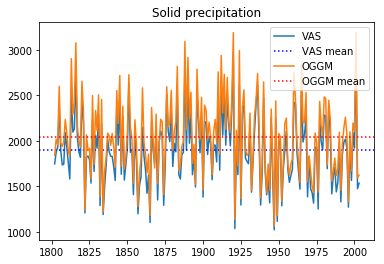

In [62]:
plt.plot(years, prcp, label='VAS')
plt.axhline(prcp.mean(), c='b', ls=':', label='VAS mean')
plt.plot(years_oggm, prcp_oggm, label='OGGM')
plt.axhline(prcp_oggm.mean(), c='r', ls=':', label='OGGM mean')
plt.legend()
plt.title('Solid precipitation')
print('mean deviation [mm w.e. yr-1]:',md(prcp_oggm, prcp))

In [63]:
assert md(temp_oggm, temp) >= 0
assert md(prcp_oggm, prcp) <= 0

In [70]:
from oggm.utils import corrcoef

def anomaly_to_mean(data):
    """Computes differences/anomalies to mean"""
    return data - np.mean(data)

def corr_anomalies(ref, data):
    return corrcoef(anomaly_to_mean(ref), anomaly_to_mean(data))

Correlation: 0.9861794740973104


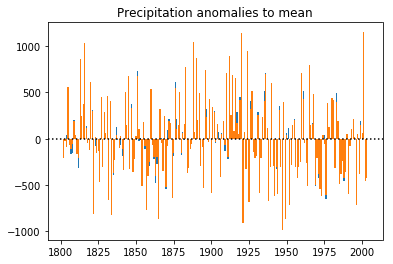

In [71]:
plt.bar(years, anomaly_to_mean(prcp))
plt.bar(years_oggm, anomaly_to_mean(prcp_oggm))
plt.axhline(0, c='k', ls=':')
plt.title('Precipitation anomalies to mean')
print('Correlation:', corr_anomalies(prcp, prcp_oggm))

In [103]:
# read the Hintereisferner DEM
hef_file = get_demo_file('Hintereisferner_RGI5.shp')
entity = gpd.read_file(hef_file).iloc[0]

# initialize the GlacierDirectory
gdir = oggm.GlacierDirectory(entity, base_dir=self.testdir)
# define the local grid and glacier mask
gis.define_glacier_region(gdir, entity=entity)
gis.glacier_masks(gdir)

# process the given climate file
climate.process_custom_climate_data(gdir)

# run center line preprocessing tasks
centerlines.compute_centerlines(gdir)
centerlines.initialize_flowlines(gdir)
centerlines.compute_downstream_line(gdir)
centerlines.compute_downstream_bedshape(gdir)
centerlines.catchment_area(gdir)
centerlines.catchment_intersections(gdir)
centerlines.catchment_width_geom(gdir)
centerlines.catchment_width_correction(gdir)

# read reference glacier mass balance data
mbdf = gdir.get_ref_mb_data()
# compute the reference t* for the glacier
# given the reference of mass balance measurements
res = climate.t_star_from_refmb(gdir, mbdf=mbdf['ANNUAL_BALANCE'])
t_star, bias = res['t_star'], res['bias']

# --------------------
#  SCALING MODEL
# --------------------

# compute local t* and the corresponding mu*
vascaling.local_t_star(gdir, tstar=t_star, bias=bias)

# instance the mass balance models
vas_mbmod = vascaling.VAScalingMassBalance(gdir)

# get reference area
a0 = gdir.rgi_area_m2
# get reference year
y0 = gdir.read_pickle('climate_info')['baseline_hydro_yr_0']
# get min and max glacier surface elevation
h0, h1 = vascaling.get_min_max_elevation(gdir)

vas_model = vascaling.VAScalingModel(year_0=y0, area_m2_0=a0,
                                     min_hgt=h0, max_hgt=h1,
                                     mb_model=vas_mbmod)

# let model run over entire HistAlp climate period
years_vas, length_m_vas, area_m2_vas, volume_m3_vas, _ = \
    vas_model.run_until(2003)

# ------
#  OGGM
# ------

# compute local t* and the corresponding mu*
climate.local_t_star(gdir, tstar=t_star, bias=bias)
climate.mu_star_calibration(gdir)

# instance the mass balance models
mb_mod = massbalance.PastMassBalance(gdir)

# performe ice thickness inversion
inversion.prepare_for_inversion(gdir)
inversion.mass_conservation_inversion(gdir)
inversion.filter_inversion_output(gdir)

# initialize present time glacier
flowline.init_present_time_glacier(gdir)

# instance flowline model
fls = gdir.read_pickle('model_flowlines')
y0 = gdir.read_pickle('climate_info')['baseline_hydro_yr_0']
fl_mod = flowline.FluxBasedModel(flowlines=fls, mb_model=mb_mod, y0=y0)

# run model and store output as xarray data set
_, oggm_ds = fl_mod.run_until_and_store(2003)

years_oggm = oggm_ds.hydro_year.values
length_m_oggm = oggm_ds.length_m.values
area_m2_oggm = oggm_ds.area_m2.values
volume_m3_oggm = oggm_ds.volume_m3

2019-01-30 15:55:22: oggm.core.gis: (RGI50-11.00897) define_glacier_region
2019-01-30 15:55:22: oggm.core.gis: (RGI50-11.00897) glacier_masks
2019-01-30 15:55:23: oggm.core.climate: (RGI50-11.00897) process_custom_climate_data
2019-01-30 15:55:23: oggm.core.centerlines: (RGI50-11.00897) compute_centerlines
2019-01-30 15:55:24: oggm.core.centerlines: (RGI50-11.00897) initialize_flowlines
2019-01-30 15:55:24: oggm.core.centerlines: (RGI50-11.00897) compute_downstream_line
2019-01-30 15:55:24: oggm.core.centerlines: (RGI50-11.00897) compute_downstream_bedshape
2019-01-30 15:55:24: oggm.core.centerlines: (RGI50-11.00897) catchment_area
2019-01-30 15:55:27: oggm.core.centerlines: (RGI50-11.00897) catchment_intersections
2019-01-30 15:55:28: oggm.core.centerlines: (RGI50-11.00897) catchment_width_geom
2019-01-30 15:55:29: oggm.core.centerlines: (RGI50-11.00897) catchment_width_correction
2019-01-30 15:55:30: oggm.core.climate: (RGI50-11.00897) t_star_from_refmb
2019-01-30 15:55:30: oggm.core

In [125]:
from oggm.utils import rel_err
vas = area_m2_vas
oggm = area_m2_oggm
# the relative error between VAS and OGGM area must not succeed 5% in
        # any given year.
        np.testing.assert_array_less(np.abs(rel_err(area_m2_oggm,
                                                    area_m2_vas)),
                                     0.05)

In [131]:
from oggm.utils import rmsd

def rmsd_anomalies(ref, data):
    return rmsd(ref - np.mean(ref), data - np.mean(data))

def rel_err_anom(ref, data):
    return rel_err(ref - np.mean(ref), data - np.mean(data))

In [124]:
oggm = length_m_oggm
vas = length_m_vas
print(rmsd(oggm, vas)/1e3)
print(rmsd_anomalies(oggm, vas))

1.7844869244030237
253.35407719297407


In [127]:
print(rmsd(oggm, vas)/1e6)
print(rmsd_anomalies(oggm, vas))

0.15651830080950846
153057.6148955129


In [72]:
print('Correlation:', corrcoef(prcp, prcp_oggm))
print('Correlation of anomalies:', corr_anomalies(prcp, prcp_oggm))

Correlation: 0.9861794740973103
Correlation of anomalies: 0.9861794740973104


In [75]:
# bias does not affect correlation -> OBVIOUSOLY!
np.testing.assert_almost_equal(corrcoef(prcp, prcp_oggm), corr_anomalies(prcp, prcp_oggm))

In [88]:

# instance mb models
vas_mbmod = vascaling.VAScalingMassBalance(gdir)
past_mbmod = massbalance.PastMassBalance(gdir)

# get relevant glacier surface elevation
min_hgt, max_hgt = vascaling.get_min_max_elevation(gdir)

# define temporal range
ys = 1802
ye = 2003
years = np.arange(ys, ye + 1)

# get flow lines
fls = gdir.read_pickle('inversion_flowlines')

# create empty container
past_mb = np.empty(years.size)
vas_mb = np.empty(years.size)
# get specific mass balance for all years
for i, year in enumerate(years):
    past_mb[i] = past_mbmod.get_specific_mb(fls=fls, year=year)
    vas_mb[i] = vas_mbmod.get_specific_mb(min_hgt, max_hgt, year)

In [100]:
np.in1d(years, mbs.index)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [93]:
mbs.index

Int64Index([1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963,
            1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974,
            1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985,
            1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996,
            1997, 1998, 1999, 2000, 2001, 2002, 2003],
           dtype='int64', name='YEAR')

In [92]:
np.where(years == mbs.index)

ValueError: Lengths must match to compare

In [102]:
corrcoef(vas_mb[np.in1d(years, mbs.index)], mbs)

0.8032994278885514

In [90]:
mbs = gdir.get_ref_mb_data()['ANNUAL_BALANCE']

In [79]:
def corr_diffs(ref, data):
    return corrcoef(np.diff(ref), np.diff(data))

In [80]:
print('Correlation:', corrcoef(prcp, prcp_oggm))
print('Correlation:', corr_diffs(prcp, prcp_oggm))

Correlation: 0.9861794740973103
Correlation: 0.9878845693045881


In [81]:
print('Correlation:', corrcoef(temp, temp_oggm))
print('Correlation:', corr_diffs(temp, temp_oggm))

Correlation: 0.9398193400690752
Correlation: 0.924239462522047


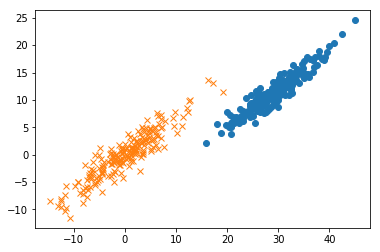

In [84]:
plt.plot(temp, temp_oggm, marker='o', ls='None')
plt.plot(np.diff(temp), np.diff(temp_oggm), marker='x', ls='None')

### Test mb model climate functions

In [4]:
# load the new module
import importlib
from oggm.core import vascaling as ben
from oggm.tests import test_vascaling as test_ben

importlib.reload(ben)
importlib.reload(test_ben)

<module 'oggm.tests.test_vascaling' from '/Users/oberrauch/oggm-fork/oggm/tests/test_vascaling.py'>

In [6]:
# instanciate and set up test
test = test_ben.TestVAScalingModel()
test.setUp()
# quick and dirty
self = test

2019-01-30 14:35:41: oggm.cfg: Parameter file: /Users/oberrauch/oggm-fork/oggm/params.cfg


In [7]:
# read the Hintereisferner DEM
hef_file = get_demo_file('Hintereisferner_RGI5.shp')
entity = gpd.read_file(hef_file).iloc[0]
# initialize the GlacierDirectory
gdir = oggm.GlacierDirectory(entity, base_dir=self.testdir)
# define the local grid and the glacier mask
gis.define_glacier_region(gdir, entity=entity)
gis.glacier_masks(gdir)

# process the given climate file
climate.process_custom_climate_data(gdir)

# run centerline prepro tasks
centerlines.compute_centerlines(gdir)
centerlines.initialize_flowlines(gdir)
centerlines.catchment_area(gdir)
centerlines.catchment_intersections(gdir)
centerlines.catchment_width_geom(gdir)
centerlines.catchment_width_correction(gdir)

# read reference glacier mass balance data
mbdf = gdir.get_ref_mb_data()
# compute the reference t* for the glacier
# given the reference of mass balance measurements
res = climate.t_star_from_refmb(gdir, mbdf=mbdf['ANNUAL_BALANCE'])
t_star, bias = res['t_star'], res['bias']

2019-01-30 14:35:43: oggm.core.gis: (RGI50-11.00897) define_glacier_region
2019-01-30 14:35:43: oggm.core.gis: (RGI50-11.00897) glacier_masks
2019-01-30 14:35:43: oggm.core.climate: (RGI50-11.00897) process_custom_climate_data
2019-01-30 14:35:44: oggm.core.centerlines: (RGI50-11.00897) compute_centerlines
2019-01-30 14:35:44: oggm.core.centerlines: (RGI50-11.00897) initialize_flowlines
2019-01-30 14:35:45: oggm.core.centerlines: (RGI50-11.00897) catchment_area
2019-01-30 14:35:48: oggm.core.centerlines: (RGI50-11.00897) catchment_intersections
2019-01-30 14:35:48: oggm.core.centerlines: (RGI50-11.00897) catchment_width_geom
2019-01-30 14:35:49: oggm.core.centerlines: (RGI50-11.00897) catchment_width_correction
2019-01-30 14:35:49: oggm.core.climate: (RGI50-11.00897) t_star_from_refmb


In [11]:
# compute local t* and the corresponding mu*
ben.local_t_star(gdir, tstar=t_star, bias=bias)
# read calibration results
ben_params = gdir.read_json('vascaling_mustar')
ben_params

{'rgi_id': 'RGI50-11.00897',
 't_star': 1879,
 'bias': -12.407504191161365,
 'mu_star': 70.48519842109663}

In [12]:
# get min and max height
min_hgt, max_hgt = ben.get_min_max_elevation(gdir)

In [13]:
# get all month of that year in the
# floating (hydrological) year convention
year = 2000
months = np.linspace(year, year+1, num=12, endpoint=False)

In [16]:
# instanciate mb model
mbmod = ben.VAScalingMassBalance(gdir)

In [23]:
# create containers
temp = np.empty(12)
prcp = np.empty(12)
# get mb relevant climate data for every month
for i, month in enumerate(months):
    _temp, _prcp = mbmod.get_monthly_climate(min_hgt, max_hgt, month)
    temp[i] = _temp
    prcp[i] = _prcp

In [24]:
# get labels for months of hydrological year
import calendar
hydro_months = np.append(np.arange(10, 13), np.arange(1, 10))
hydro_names = [calendar.month_name[hydro] for hydro in hydro_months]

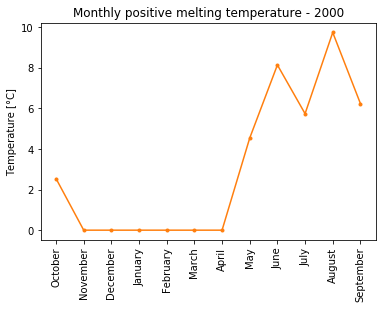

In [25]:
plt.plot(months, temp, c='C1', marker='.')
plt.ylabel('Temperature [°C]')
plt.title('Monthly positive melting temperature - {}'.format(int(year)))
plt.xticks(months, hydro_names, rotation=90);

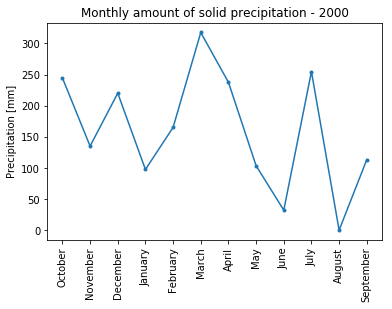

In [26]:
plt.plot(months, prcp, c='C0', marker='.')
plt.ylabel('Precipitation [mm]')
plt.title('Monthly amount of solid precipitation - {}'.format(int(year)))
plt.xticks(months, hydro_names, rotation=90);

In [27]:
# read the climate file
climate_nc = utils.ncDataset(gdir.get_filepath('climate_monthly'), mode='r')
climate_nc

<class 'oggm.utils.ncDataset'>
root group (NETCDF4 data model, file format HDF5):
    ref_hgt: 3160.0
    ref_pix_lon: 10.74999999999735
    ref_pix_lat: 46.83333333333185
    ref_pix_dis: 3728.3398390706107
    author: OGGM
    author_info: Open Global Glacier Model
    dimensions(sizes): time(2424)
    variables(dimensions): int32 time(time), float32 prcp(time), float32 temp(time)
    groups: 

In [28]:
year = 2000

#### The OGGM method `get_annual_climate()`

In [29]:
from oggm.core.massbalance import PastMassBalance
# run OGGM mu* calibration
climate.local_t_star(gdir, tstar=t_star, bias=bias)
climate.mu_star_calibration(gdir)

2019-01-30 14:36:57: oggm.core.climate: (RGI50-11.00897) local_t_star
2019-01-30 14:36:57: oggm.core.climate: (RGI50-11.00897) local mu* for t*=1879
2019-01-30 14:36:57: oggm.core.climate: (RGI50-11.00897) mu_star_calibration


In [30]:
# instanciate the past mass balance model
past_mbmod = PastMassBalance(gdir)

In [31]:
heights = np.array([min_hgt, (min_hgt + max_hgt)/2, max_hgt])
_, temp_for_melt_oggm, _, prcp_solid_oggm = past_mbmod.get_annual_climate(heights, year)

In [32]:
# view values
print('Cumulated annual energy input in form of positive melting temperature [°C]:')
_text = ['{:.2f}°C at {:.0f} m asl.;'.format(_temp, _elev) for _elev, _temp in zip(heights, temp_for_melt_oggm)]
print(_text[0], _text[1], _text[2])

Cumulated annual energy input in form of positive melting temperature [°C]:
36.95°C at 2446 m asl.; 14.29°C at 3065 m asl.; 1.79°C at 3684 m asl.;


In [33]:
# view values
print('Cumulated annual mass input in form of solid precipitation [mm]:')
_text = ['{:.2f} mm at {:.0f} m asl.;'.format(_prcp, _elev) for _elev, _prcp in zip(heights, prcp_solid_oggm)]
print(_text[0], _text[1], _text[2])

Cumulated annual mass input in form of solid precipitation [mm]:
1242.10 mm at 2446 m asl.; 2184.59 mm at 3065 m asl.; 3191.96 mm at 3684 m asl.;


#### My method `get_annual_climate()`

In [35]:
temp_for_melt, prcp_solid = mbmod.get_annual_climate(min_hgt, max_hgt, year)

In [181]:
# sum monthly temperature values
temp_for_melt = temp_for_melt.sum()
temp_for_melt

36.946003

In [182]:
# sum monthly precipitation values
prcp_solid = prcp_solid.sum()
prcp_solid

1920.7805

In [183]:
abs(1 - prcp_solid/prcp_solid_oggm[1])

0.12075793743133545

### Test the specific mass balance functions

In [217]:
importlib.reload(ben)
importlib.reload(test_ben)

<module 'oggm.tests.test_ben' from '/Users/oberrauch/oggm-fork/oggm/tests/test_ben.py'>

In [218]:
self = test_ben.TestBensModel()
self.setUp()

2019-01-13 21:07:03: oggm.cfg: Parameter file: /Users/oberrauch/oggm-fork/oggm/params.cfg


In [219]:
gdir = self._setup_mb_test()

2019-01-13 21:07:05: oggm.core.gis: (RGI50-11.00897) define_glacier_region
2019-01-13 21:07:06: oggm.core.gis: (RGI50-11.00897) glacier_masks
2019-01-13 21:07:06: oggm.core.climate: (RGI50-11.00897) process_custom_climate_data
2019-01-13 21:07:06: oggm.core.centerlines: (RGI50-11.00897) compute_centerlines
2019-01-13 21:07:07: oggm.core.centerlines: (RGI50-11.00897) initialize_flowlines
2019-01-13 21:07:07: oggm.core.centerlines: (RGI50-11.00897) catchment_area
2019-01-13 21:07:10: oggm.core.centerlines: (RGI50-11.00897) catchment_intersections
2019-01-13 21:07:10: oggm.core.centerlines: (RGI50-11.00897) catchment_width_geom
2019-01-13 21:07:13: oggm.core.centerlines: (RGI50-11.00897) catchment_width_correction
2019-01-13 21:07:13: oggm.core.climate: (RGI50-11.00897) t_star_from_refmb
2019-01-13 21:07:14: oggm.core.climate: (RGI50-11.00897) local_t_star
2019-01-13 21:07:14: oggm.core.climate: (RGI50-11.00897) local mu* for t*=1879
2019-01-13 21:07:14: oggm.core.climate: (RGI50-11.00897

In [220]:
# instance mb models
ben_mbmod = ben.BenMassBalance(gdir)
past_mbmod = massbalance.PastMassBalance(gdir)

In [379]:
# define temporal range
ys = 1802
ye = 2003
years = np.arange(ys, ye+1)

In [269]:
# get flowlines
fls = gdir.read_pickle('inversion_flowlines')

In [270]:
# create empty container
past_mb = np.empty(years.size)
# get specific mass balance for all years
for i, year in enumerate(years):
    past_mb[i] = past_mbmod.get_specific_mb(fls=fls, year=year)

Text(0,0.5,'Mass balance [mm w.e. yr$^{-1}$]')

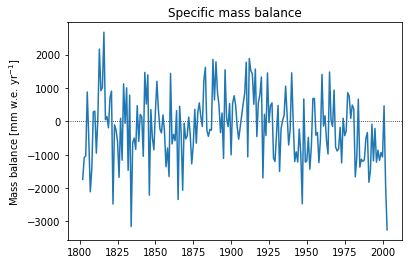

In [228]:
plt.axhline(0, c='k', ls=':', lw=0.8)
plt.plot(years, past_mb)
plt.title('Specific mass balance - OGGM')
plt.ylabel('Mass balance [mm w.e. yr$^{-1}$]')

In [229]:
# get relevant glacier surface elevation
min_hgt, max_hgt = ben.get_min_max_elevation(gdir)

In [230]:
# create empty container
ben_mb = np.empty(years.size)
# get specific mass balance for all years
for i, year in enumerate(years):
    ben_mb[i] = ben_mbmod.get_specific_mb(min_hgt, max_hgt, year)

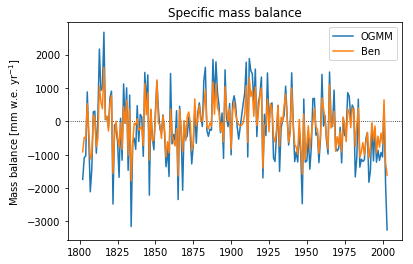

In [231]:
plt.axhline(0, c='k', ls=':', lw=0.8)
plt.plot(years, past_mb, label='OGMM')
plt.plot(years, ben_mb, label='Ben')
plt.title('Specific mass balance')
plt.ylabel('Mass balance [mm w.e. yr$^{-1}$]')
plt.legend()

Well, that looks all nice and what not. But we need some numbers...

In [262]:
# compute ans check correlation
assert np.corrcoef(past_mb, ben_mb)[0,1] > 0.9

In [263]:
# compute average
past_avg = past_mb.mean()
ben_avg = ben_mb.mean()
# check relative error
assert (1 - ben_avg/past_avg) < 0.3

In [264]:
# check signs
past_sign = np.sign(past_mb)
ben_sign = np.sign(ben_mb)
assert np.corrcoef(past_sign, ben_sign)[0,1] >= 0.75

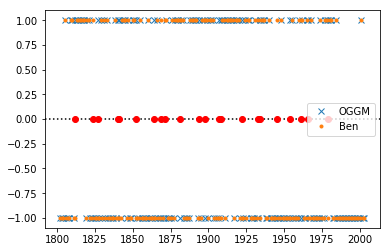

In [258]:
# visualize signs
unequal = (past_sign == ben_sign).astype(float)
unequal[unequal == 1] = np.nan
plt.axhline(0, c='k', ls=':')
plt.plot(years, past_sign, label='OGGM', ls='None', marker='x')
plt.plot(years, ben_sign, label='Ben', ls='None', marker='.')
plt.plot(years, unequal, ls='None', marker='o', color='r')
plt.legend()

#### Test the monthly specific mass balance against the yearly specific mass balance

In [317]:
importlib.reload(ben)
ben_mbmod = ben.BenMassBalance(gdir)

In [318]:
# get all month of that year in the
# floating (hydrological) year convention
year = 1803
months = np.linspace(year, year+1, num=12, endpoint=False)

In [319]:
# compute monthly specific mass balance for
# all month of given year and store in array
spec_mb_month = np.empty(months.size)
for i, month in enumerate(months):
    spec_mb_month[i] = ben_mbmod.get_monthly_specific_mb(min_hgt, max_hgt, month)

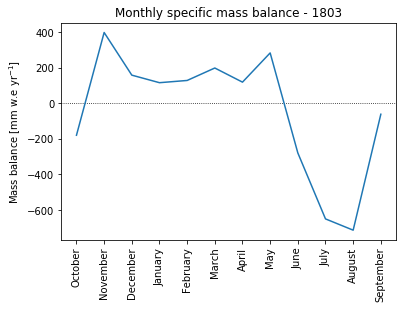

In [320]:
plt.axhline(0, c='k', ls=':', lw=0.8)
plt.plot(hydro_names, spec_mb_month)
plt.ylabel('Mass balance [mm w.e yr$^{-1}$]')
plt.title('Monthly specific mass balance - {}'.format(year))
plt.xticks(rotation=90);

In [341]:
print('Sum of monthly spec mb {:.3f} mm we. yr-1'.format(spec_mb_month.sum()))

Sum of monthly spec mb -481.70 mm we. yr-1


In [343]:
print('Annual spec mb {:.3f} mm we. yr-1'.format(ben_mbmod.get_specific_mb(min_hgt, max_hgt, year)))

Annual spec mb -481.699 mm we. yr-1


### Test the actual mass balance functions

In [217]:
importlib.reload(ben)
importlib.reload(test_ben)

<module 'oggm.tests.test_ben' from '/Users/oberrauch/oggm-fork/oggm/tests/test_ben.py'>

In [344]:
self = test_ben.TestBensModel()
self.setUp()

2019-01-14 17:51:08: oggm.cfg: Parameter file: /Users/oberrauch/oggm-fork/oggm/params.cfg


In [345]:
gdir = self._setup_mb_test()

2019-01-14 17:51:09: oggm.core.gis: (RGI50-11.00897) define_glacier_region
2019-01-14 17:51:09: oggm.core.gis: (RGI50-11.00897) glacier_masks
2019-01-14 17:51:09: oggm.core.climate: (RGI50-11.00897) process_custom_climate_data
2019-01-14 17:51:09: oggm.core.centerlines: (RGI50-11.00897) compute_centerlines
2019-01-14 17:51:10: oggm.core.centerlines: (RGI50-11.00897) initialize_flowlines
2019-01-14 17:51:10: oggm.core.centerlines: (RGI50-11.00897) catchment_area
2019-01-14 17:51:12: oggm.core.centerlines: (RGI50-11.00897) catchment_intersections
2019-01-14 17:51:12: oggm.core.centerlines: (RGI50-11.00897) catchment_width_geom
2019-01-14 17:51:13: oggm.core.centerlines: (RGI50-11.00897) catchment_width_correction
2019-01-14 17:51:13: oggm.core.climate: (RGI50-11.00897) t_star_from_refmb
2019-01-14 17:51:14: oggm.core.climate: (RGI50-11.00897) local_t_star
2019-01-14 17:51:14: oggm.core.climate: (RGI50-11.00897) local mu* for t*=1879
2019-01-14 17:51:14: oggm.core.climate: (RGI50-11.00897

In [347]:
# instance mb models
ben_mbmod = ben.BenMassBalance(gdir)

In [348]:
# get relevant glacier surface elevation
min_hgt, max_hgt = ben.get_min_max_elevation(gdir)

In [359]:
# define temporal range
ys = 1975
ye = 1975
years = np.array([ys, ye])

In [361]:
# get mass balance relavant climate data
_, temp, prcp = ben.get_yearly_mb_temp_prcp(gdir, year_range=[year, year])
temp = temp[0]
prcp = prcp[0]

In [363]:
# read mu* and bias from ben_params
ben_params = gdir.read_json('ben_params')
mu_star = ben_params['mu_star']
bias = ben_params['bias']

70.48519842109663

In [369]:
# compute mass balance with bias 'by hand'
mb = prcp - mu_star*temp - bias
mb / cfg.SEC_IN_YEAR / cfg.PARAMS['ice_density']

-2.9456230224540305e-09

In [357]:
ben_mbmod.get_annual_mb(min_hgt, max_hgt, year)

-2.9456240087335553e-09

In [372]:
# compute mass balance without bias 'by hand'
mb = prcp - mu_star*temp
mb / cfg.SEC_IN_YEAR / cfg.PARAMS['ice_density']

-3.3827778857200456e-09

In [370]:
ben_mbmod = ben.BenMassBalance(gdir, bias=0)
ben_mbmod.get_annual_mb(min_hgt, max_hgt, year)

-3.382778871999571e-09

In [373]:
# run the finished test
importlib.reload(test_ben)
test = test_ben.TestBensModel()
test.setUp()
test.test_annual_mb()

2019-01-14 18:12:25: oggm.cfg: Parameter file: /Users/oberrauch/oggm-fork/oggm/params.cfg
2019-01-14 18:12:25: oggm.core.gis: (RGI50-11.00897) define_glacier_region
2019-01-14 18:12:26: oggm.core.gis: (RGI50-11.00897) glacier_masks
2019-01-14 18:12:26: oggm.core.climate: (RGI50-11.00897) process_custom_climate_data
2019-01-14 18:12:26: oggm.core.centerlines: (RGI50-11.00897) compute_centerlines
2019-01-14 18:12:26: oggm.core.centerlines: (RGI50-11.00897) initialize_flowlines
2019-01-14 18:12:26: oggm.core.centerlines: (RGI50-11.00897) catchment_area
2019-01-14 18:12:28: oggm.core.centerlines: (RGI50-11.00897) catchment_intersections
2019-01-14 18:12:28: oggm.core.centerlines: (RGI50-11.00897) catchment_width_geom
2019-01-14 18:12:30: oggm.core.centerlines: (RGI50-11.00897) catchment_width_correction
2019-01-14 18:12:30: oggm.core.climate: (RGI50-11.00897) t_star_from_refmb
2019-01-14 18:12:30: oggm.core.climate: (RGI50-11.00897) local_t_star
2019-01-14 18:12:30: oggm.core.climate: (RGI

#### Real data

(1950, 2003)

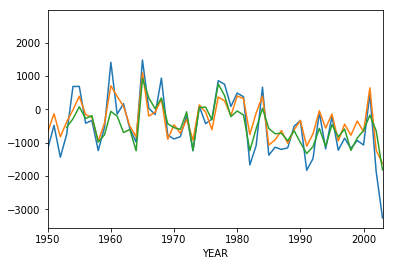

In [381]:
plt.plot(years, past_mb, label='past')
plt.plot(years, ben_mb, label='ben')
gdir.get_ref_mb_data()['ANNUAL_BALANCE'].plot()
plt.xlim([1950, 2003])

In [421]:
ref_mb = gdir.get_ref_mb_data()['ANNUAL_BALANCE']
mbs = pd.DataFrame(np.array([past_mb, ben_mb]).T, index=years, columns=['past', 'ben'])
mbs['ref'] = ref_mb
mbs.corr()

,past,ben,ref
past,1.000000,0.947227,0.851593
ben,0.947227,1.000000,0.803299
ref,0.851593,0.803299,1.000000


In [420]:
mbs = pd.DataFrame(gdir.get_ref_mb_data()['ANNUAL_BALANCE'])
mbs['ben'] = pd.Series(ben_mb, index=years)
mbs.corr().iloc[0, 1]

0.8032994278885516